## Caracal example notebook 1

This minimal notebook demonstrates how to use the core functionality of Caracal with a binary classifier model, tranied on random data.  It provides a example of how to create a ModelConfig object, a ModelWrapper, and a DataRunner to apply the run_variability_study() and plot_variability_study() functions.

In [1]:
import pandas as pd
import numpy as np
import caracal as cr  # I think this is probably the best alias to use
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Input
from caracal import ModelConfig, KerasModelWrapper, TabularDataHandler, plot_variability_summary


2025-11-18 00:22:44.980771: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 00:22:45.010549: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 00:22:45.459585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as noteboo

Enabled GPU memory growth
Loading and preparing data...
Loaded tabular data: 100 rows, 21 columns
Target column: label
Feature columns: ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12', 'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19']
Data loaded successfully

Starting Variability Study
  Runs: 16
  Epochs per run: 10
  Execution mode: in standard mode

 - Run 1: Training...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8000 - loss: 0.5753
 - Run 1: Completed successfully
 - Run 2: Training...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8000 - loss: 0.6340
 - Run 2: Completed successfully
 - Run 3: Training...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7500 - loss: 0.6411
 - Run 3: Completed successfully
 - Run 4: Training...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7000 - loss: 0.6626
 - Run 4: Completed successfully
 - Run 5: Training...
1/

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


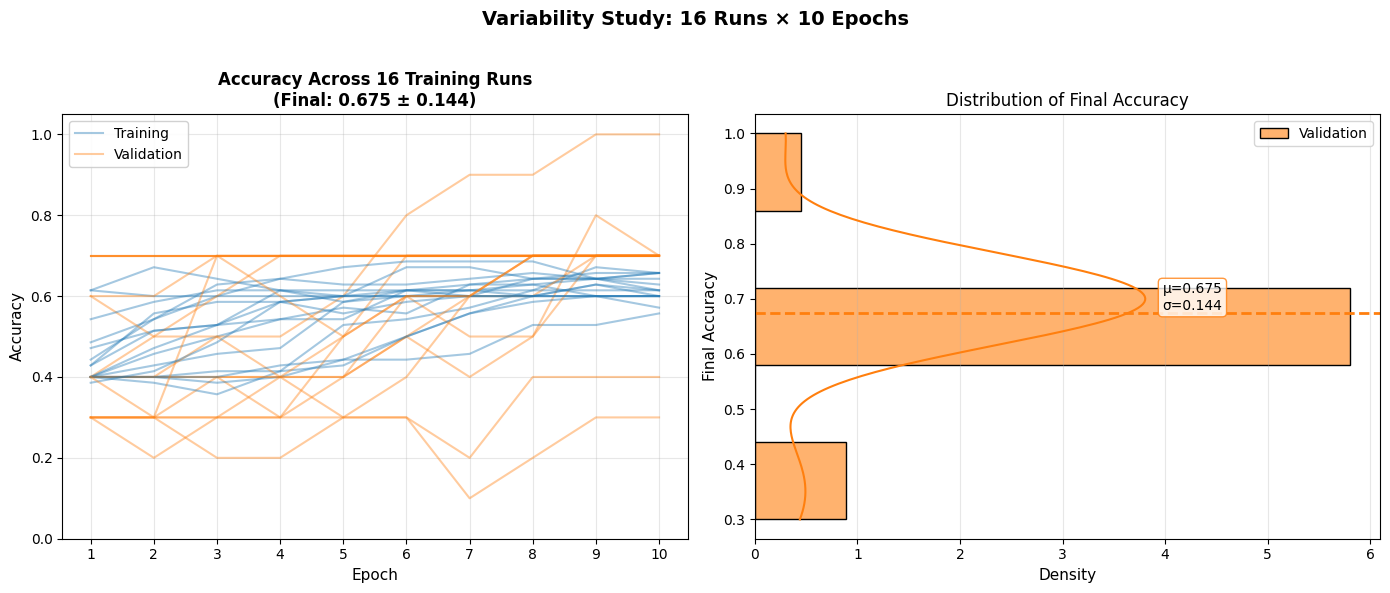

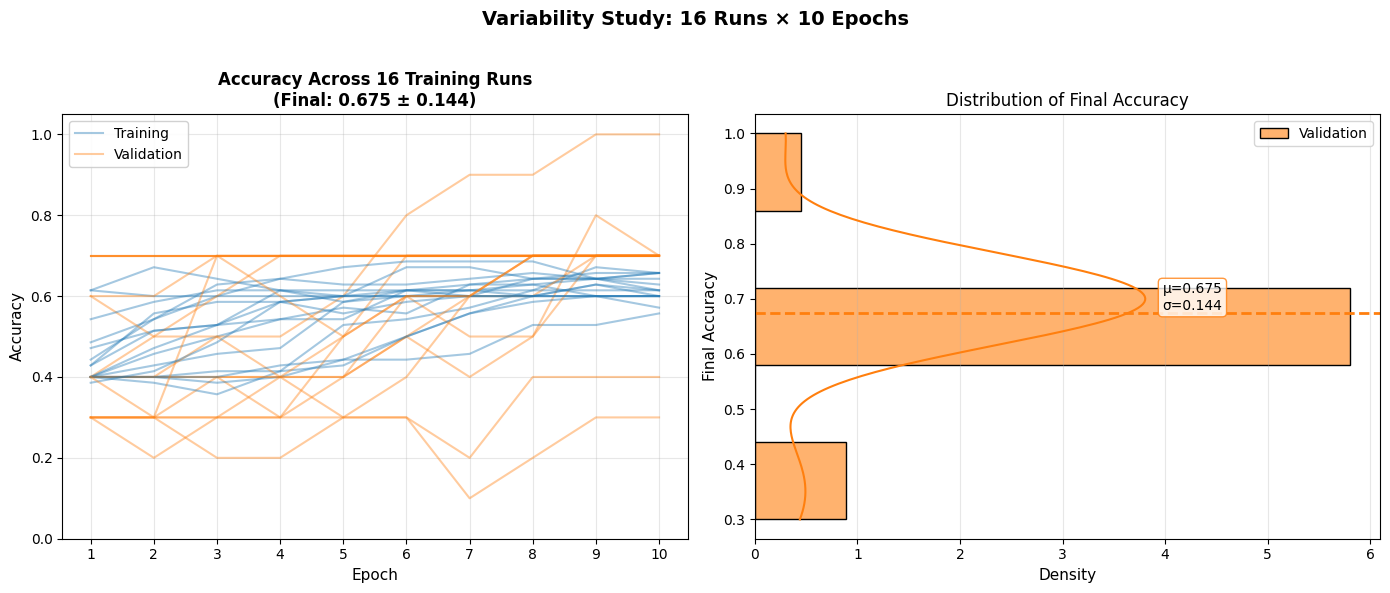

In [4]:
# Create your model config with ALL required parameters
model_config = ModelConfig({
    'epochs': 10,
    'batch_size': 32,
    'learning_rate': 0.001,
    'verbose': 0,
    'input_shape': (20,),  # 20 features for tabular data
    'num_classes': 1,      # Binary classification with sigmoid
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy']
})

def create_model(config: ModelConfig):
    """Build a neural network for tabular binary classification"""
    model = Sequential([
        Input(shape=config.get('input_shape')),  # Use get() for safety
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),  # Made smaller for small dataset
        layers.Dense(config.get('num_classes', 1), activation='sigmoid') 
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config.get('learning_rate', 0.001)),
        loss=config.get('loss', 'binary_crossentropy'), 
        metrics=config.get('metrics', ['accuracy'])
    )
    
    return KerasModelWrapper(model)

# Generate random data
data = pd.DataFrame(np.random.rand(100, 21), columns=[f'feat_{i}' for i in range(20)] + ['label'])
data['label'] = (data['label'] > 0.5).astype(int)
data.to_csv('dummy_data.csv', index=False)

data_handler = TabularDataHandler(data_path='dummy_data.csv', target_column='label')

# Run the variability study
results = cr.run_variability_study(
    model_builder=create_model,
    data_handler=data_handler,
    model_config=model_config,
    num_runs=16,
    epochs_per_run=10   # yes, this will in fact override the value provided in the ModelConfig, if it's provided here
)

# Use the enhanced results object
final_accuracies = results.get_final_metrics('val_accuracy')
print(results.summarize())

# plotting
plot_variability_summary(
    all_runs_metrics_list=results.all_runs_metrics,  
    final_metrics_series=results.final_val_accuracies,  
    final_test_series=None,  # No test data in this example
    metric='accuracy'
)